# This is the part of the code, where we train The Cannon

In [1]:
# Compatibility with Python 3
from __future__ import (absolute_import, division, print_function)

try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# Basic Tools
import numpy as np
from astropy.table import Table
import pickle
import time
import matplotlib.pyplot as plt
import scipy.optimize as op

# The Cannon
import thecannon as tc # see https://github.com/andycasey/AnniesLasso for more details

What do we have to do for the training?
Let's follow the description from https://annieslasso.readthedocs.io/en/latest/guide.html

In [2]:
# choose one grid_index
try:
    grid_index = int(sys.argv[1])
    print('Using Grid index ',grid_index)
except:
    grid_index = 1931
    print('Using default grid index ',grid_index)

In [3]:
try:
    grids = Table.read('../../spectrum_grids/galah_dr4_model_trainingset_gridpoints.fits')
    teff_logg_feh_name = str(int(grids['teff_subgrid'][grid_index]))+'_'+"{:.2f}".format(grids['logg_subgrid'][grid_index])+'_'+"{:.2f}".format(grids['fe_h_subgrid'][grid_index])

    training_set = Table.read('training_input/5750_4.50_0.00/galah_dr4_cannon_trainingset_5750_4.50_0.00_incl_vsini.fits')
    masks = Table.read('training_input/5750_4.50_0.00/5750_4.50_0.00_masks.fits')

    wavelength_file = 'training_input/galah_dr4_3dbin_thecannon_wavelength_array.pickle'
    flux_ivar_file = 'training_input/5750_4.50_0.00/galah_dr4_cannon_trainingset_5750_4.50_0.00_incl_vsini_flux_ivar.pickle'

    flux_ivar_file_opener = open(flux_ivar_file,'rb')
    training_set_flux,training_set_ivar = pickle.load(flux_ivar_file_opener)
    flux_ivar_file_opener.close()
    wavelength_file_opener = open(wavelength_file,'rb')
    wavelength_array = pickle.load(wavelength_file_opener)
    wavelength_file_opener.close()

    print('Succesfully read in all information needed for grid index '+str(grid_index)+' corresponding to '+teff_logg_feh_name)

except:
    raise ValueError('There are only '+str(len(grids))+' entries within the grid')

Succesfully read in all information needed for grid index 1931 corresponding to 5750_4.50_0.00


In [4]:
labels = tuple(training_set.keys()[2:-1])

# labels = tuple([
#     'teff', 
#     'logg', 
#     'fe_h', 
#     'vmic', 
#     'vsini', 
#     'li_fe', 
#     'c_fe', 
#     'n_fe', 
#     'o_fe', 
#     'na_fe', 
#     'mg_fe', 
#     'al_fe', 
#     'si_fe', 
#     'k_fe', 
#     'ca_fe', 
#     'sc_fe', 
#     'ti_fe', 
#     'v_fe', 
#     'cr_fe', 
#     'mn_fe', 
#     'co_fe', 
#     'ni_fe', 
#     'cu_fe', 
#     #'zn_fe', 
#     #'rb_fe', 
#     #'sr_fe', 
#     'y_fe', 
#     #'zr_fe', 
#     #'mo_fe', 
#     #'ru_fe', 
#     'ba_fe', 
#     #'la_fe', 
#     'ce_fe', 
#     #'nd_fe', 
#     #'sm_fe', 
#     #'eu_fe'
# ])

print('Labels to be fitted: ',len(labels))
print(labels)

Labels to be fitted:  36
('teff', 'logg', 'fe_h', 'vmic', 'vsini', 'li_fe', 'c_fe', 'n_fe', 'o_fe', 'na_fe', 'mg_fe', 'al_fe', 'si_fe', 'k_fe', 'ca_fe', 'sc_fe', 'ti_fe', 'v_fe', 'cr_fe', 'mn_fe', 'co_fe', 'ni_fe', 'cu_fe', 'zn_fe', 'rb_fe', 'sr_fe', 'y_fe', 'zr_fe', 'mo_fe', 'ru_fe', 'ba_fe', 'la_fe', 'ce_fe', 'nd_fe', 'sm_fe', 'eu_fe')


In [8]:
order = 2

model_file = 'galah_dr4_thecannon_model_'+teff_logg_feh_name+'_order'+str(order)+'_'+str(len(labels))+'labels'

try:
    model = tc.CannonModel.read('models/'+model_file+'.model')
    print('Model already exists')
except:    
    print('Will create The Cannon model to be stored at ')
    print('models/'+model_file+'.model')

Model already exists


In [6]:
# Convert training set labels into The Cannon readible format
training_set_labels = Table()
for label in labels:
    training_set_labels[label] = training_set[label]

In [7]:
model = tc.CannonModel(
    training_set_labels, training_set_flux, training_set_ivar,
    vectorizer=tc.vectorizer.PolynomialVectorizer(labels, order),dispersion=wavelength_array)

In [ ]:
# Apply censoring
for label in enumerate(labels):
    if label[1] not in ['teff','logg','fe_h','vmic','vsini']:
        model.censors[label[1]] = masks[label[1]]

In [ ]:
# This is where the magic happens! We train the Cannon! 
if not model.is_trained:
    theta, s2, metadata = model.train(threads=1)

In [ ]:
model.write('models/'+model_file+'.model')

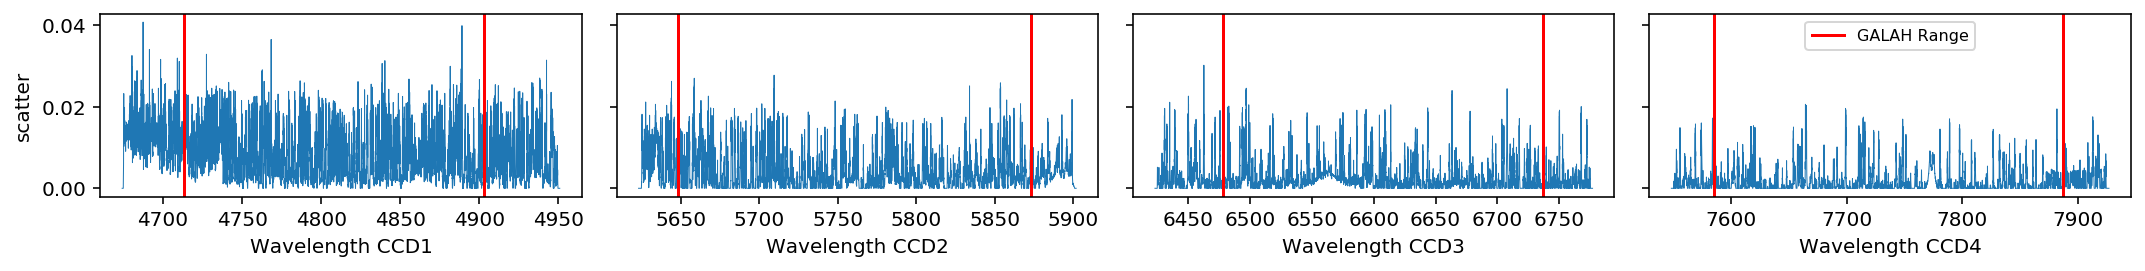

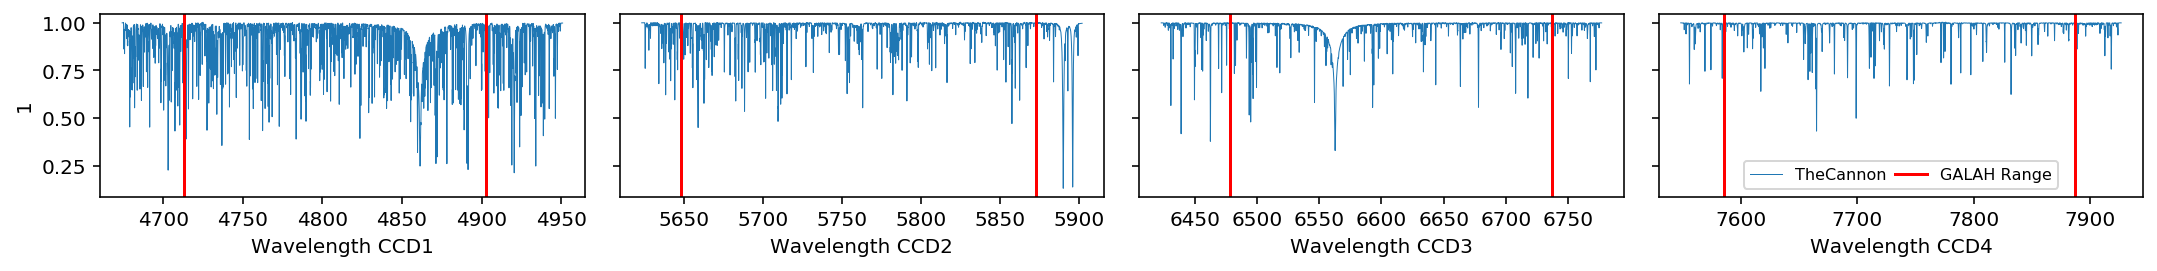

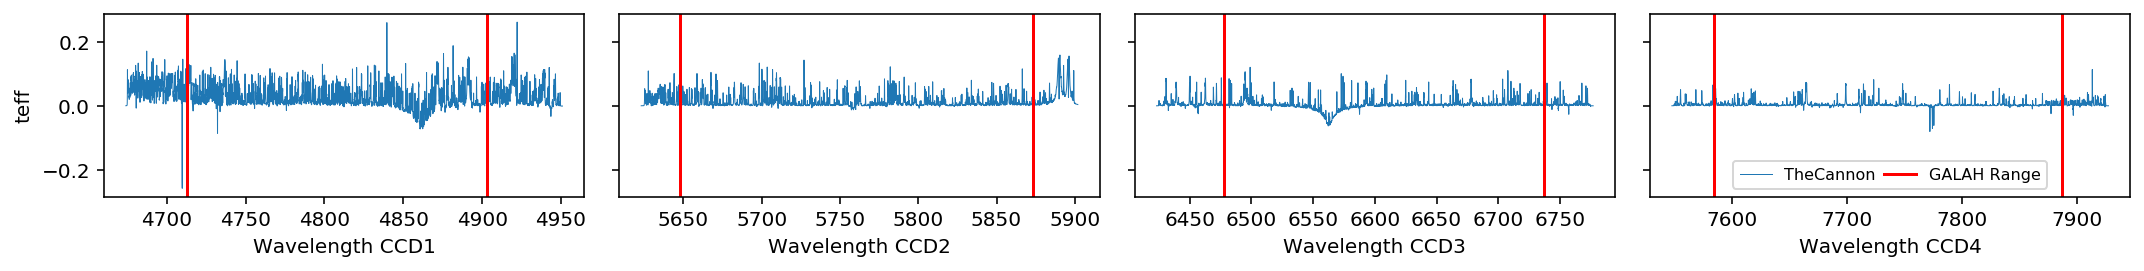

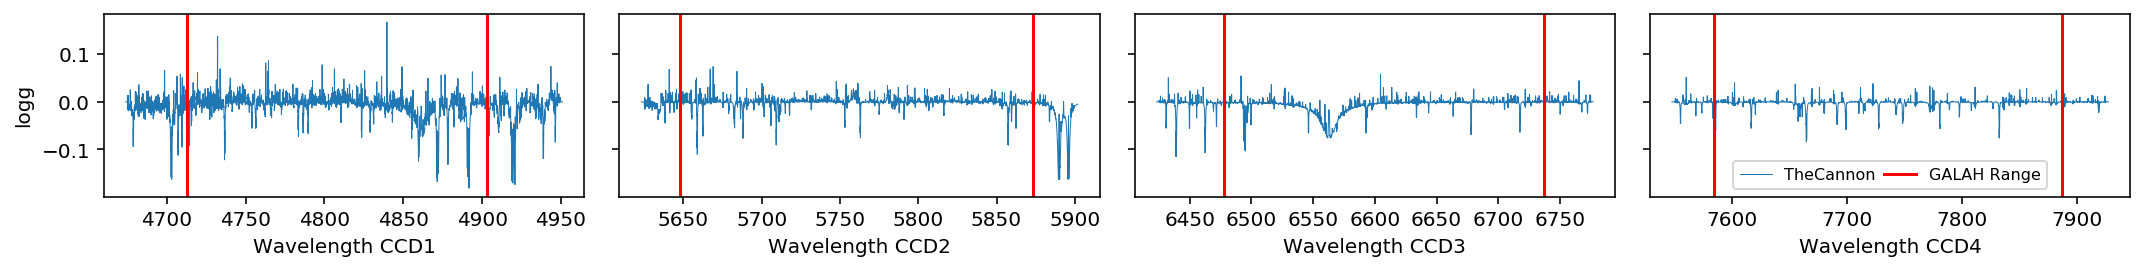

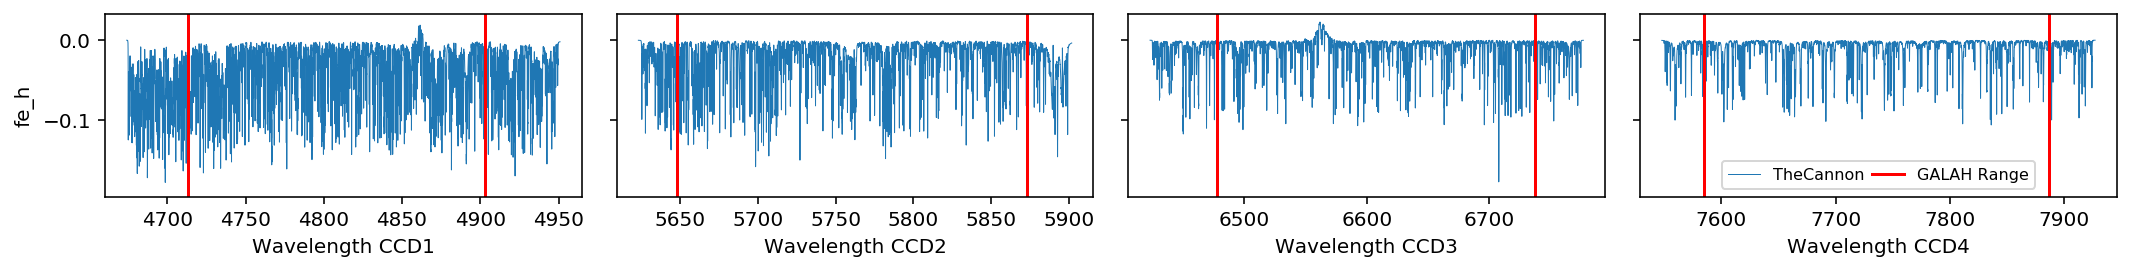

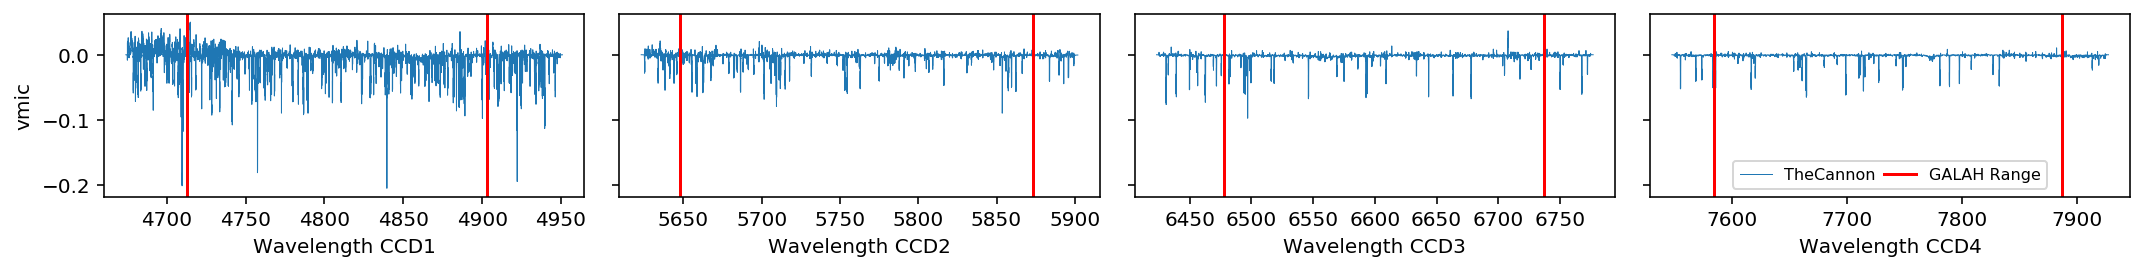

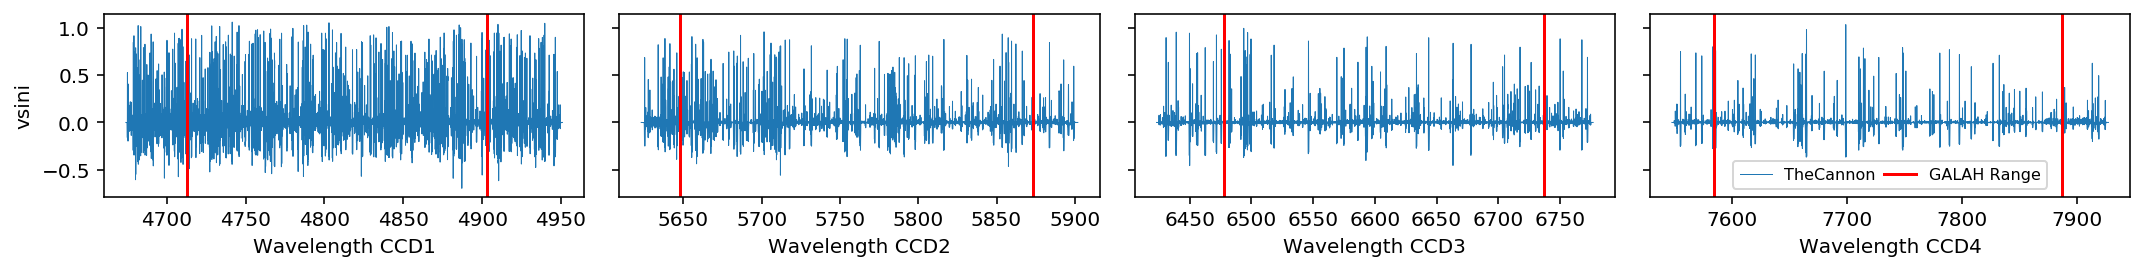

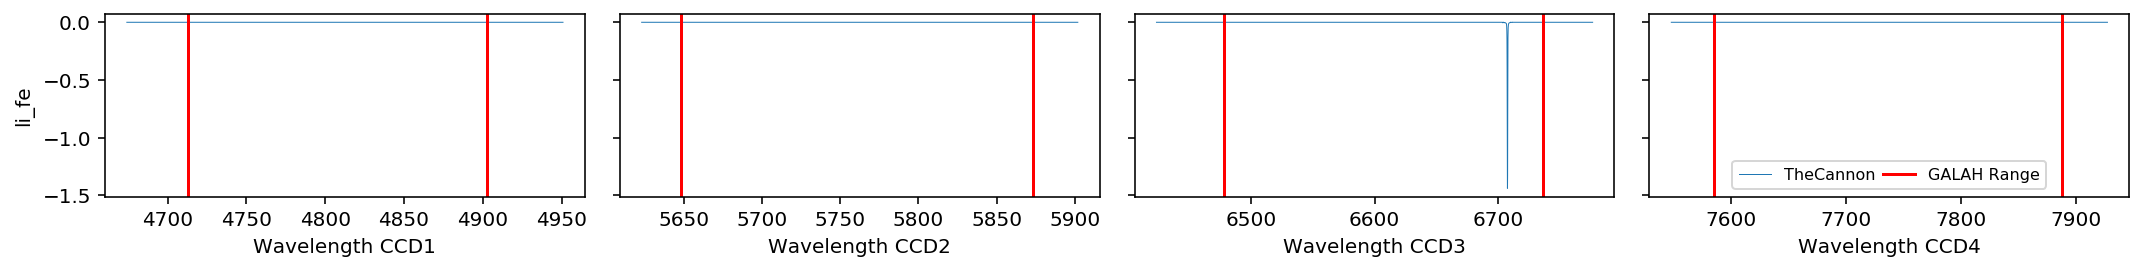

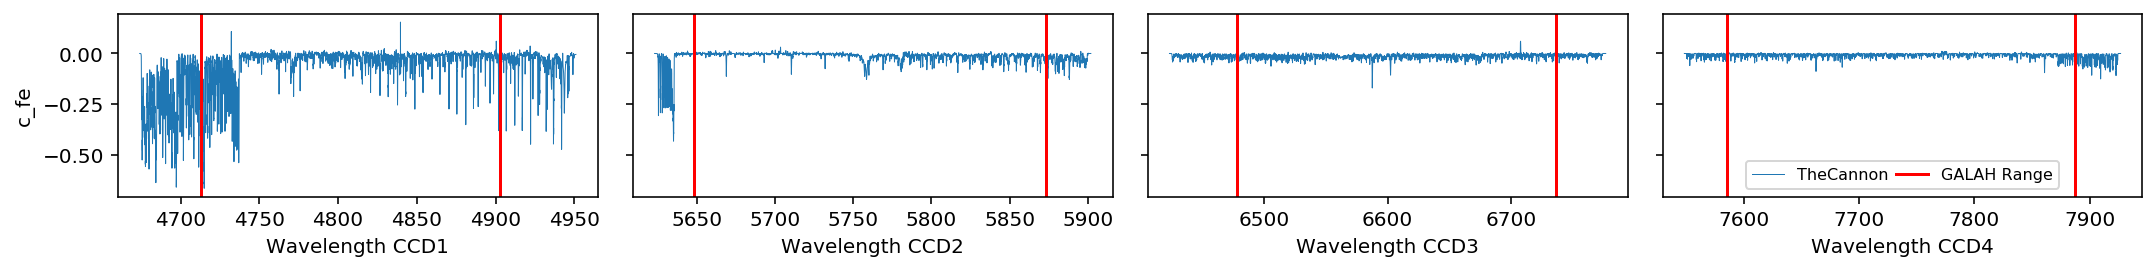

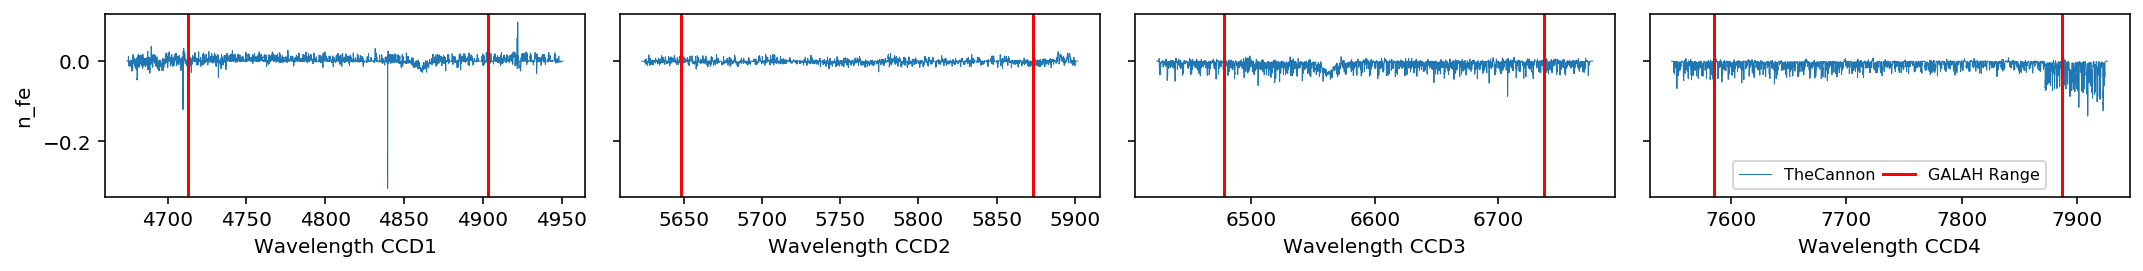

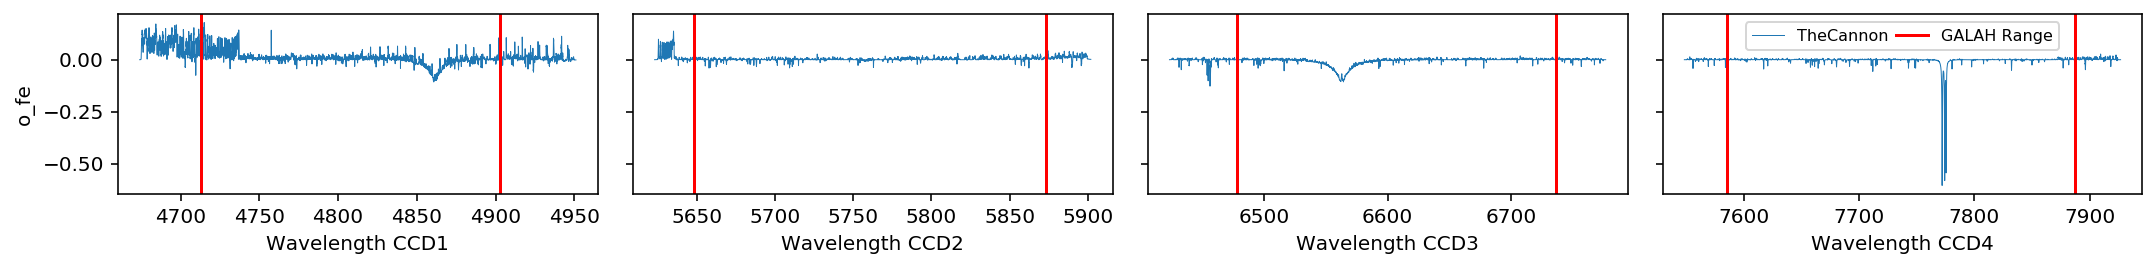

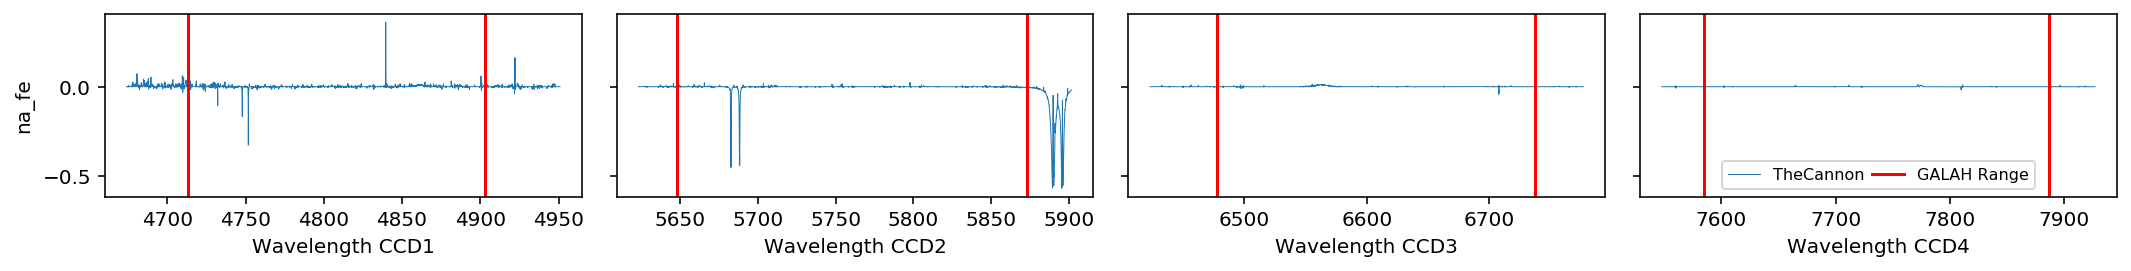

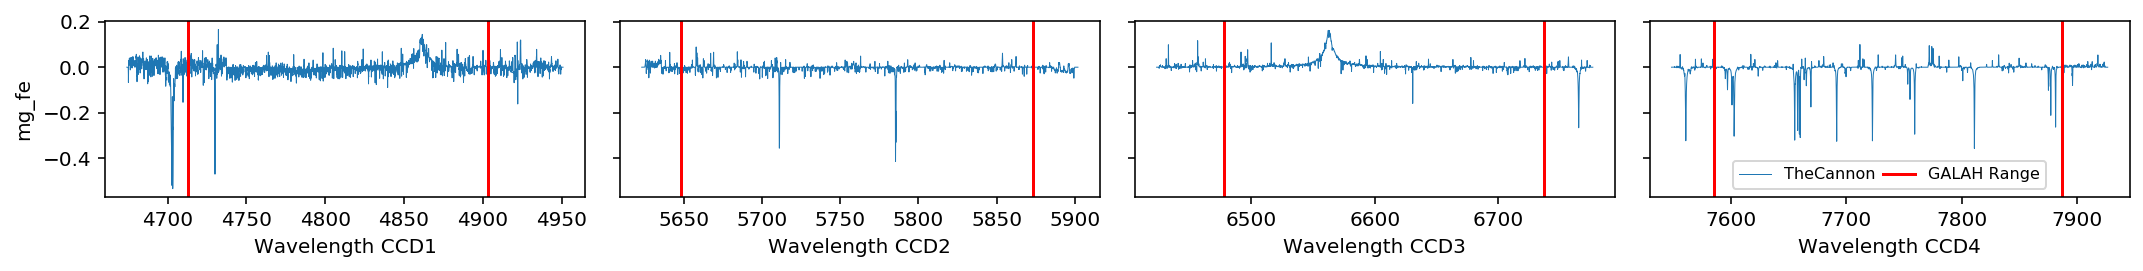

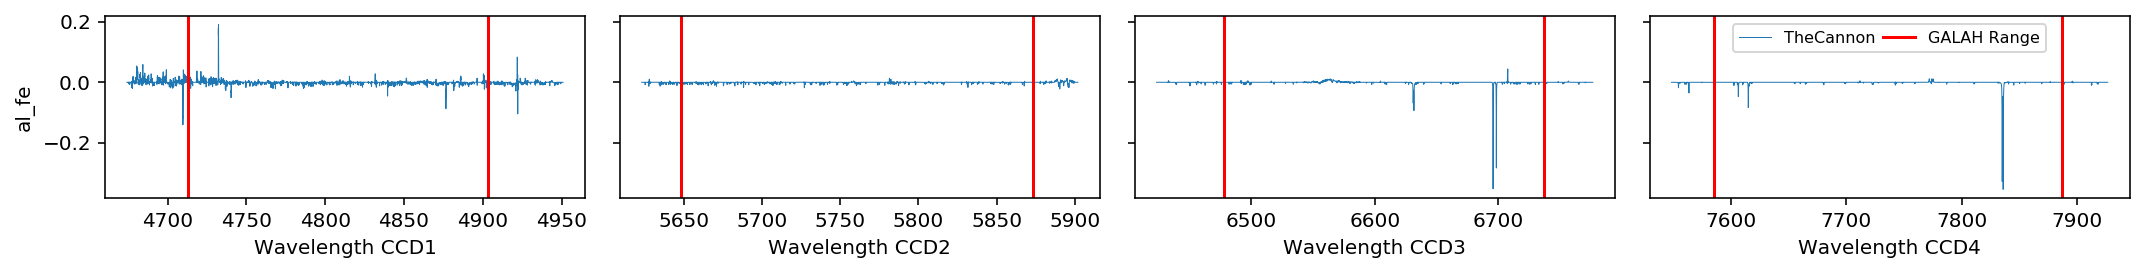

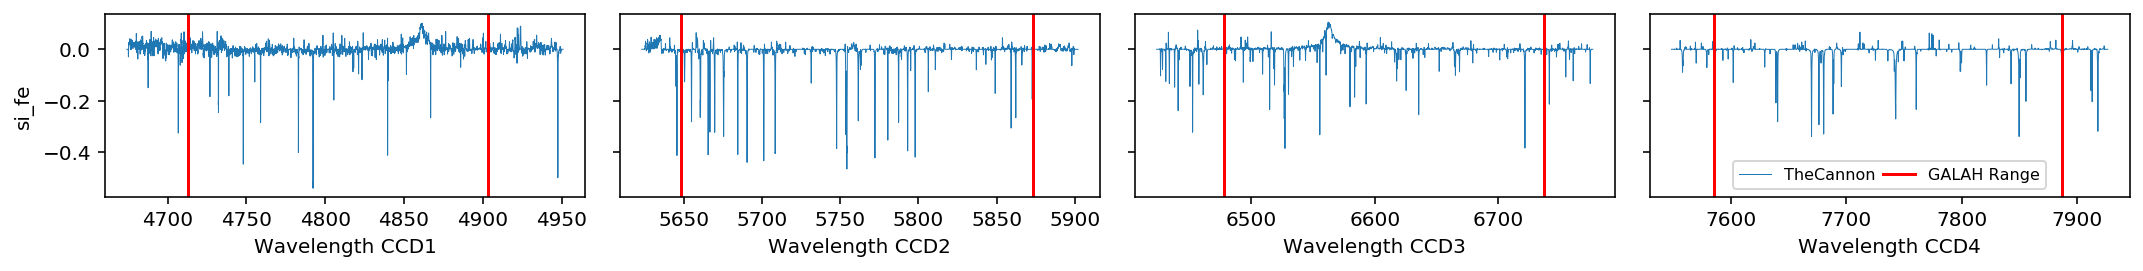

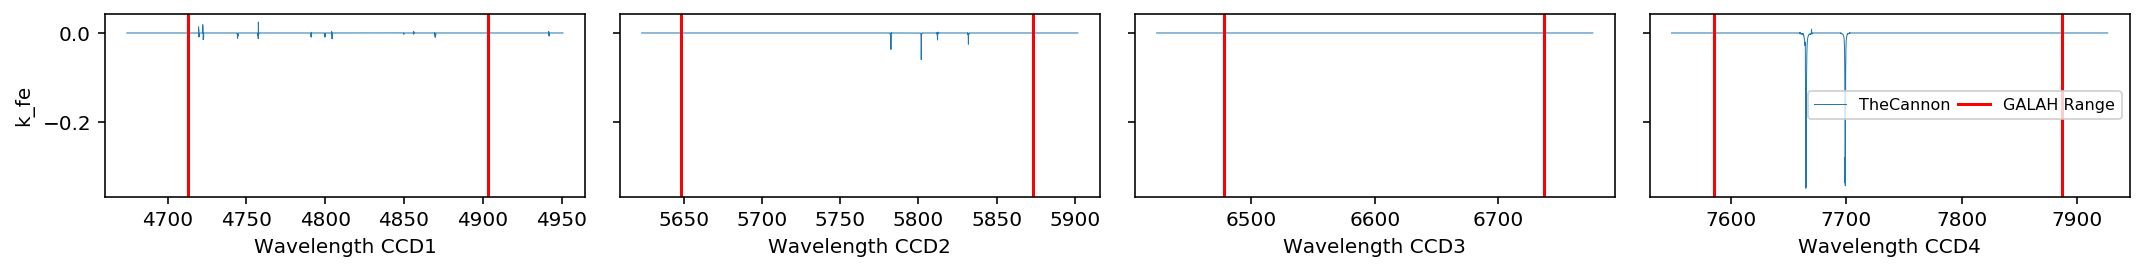

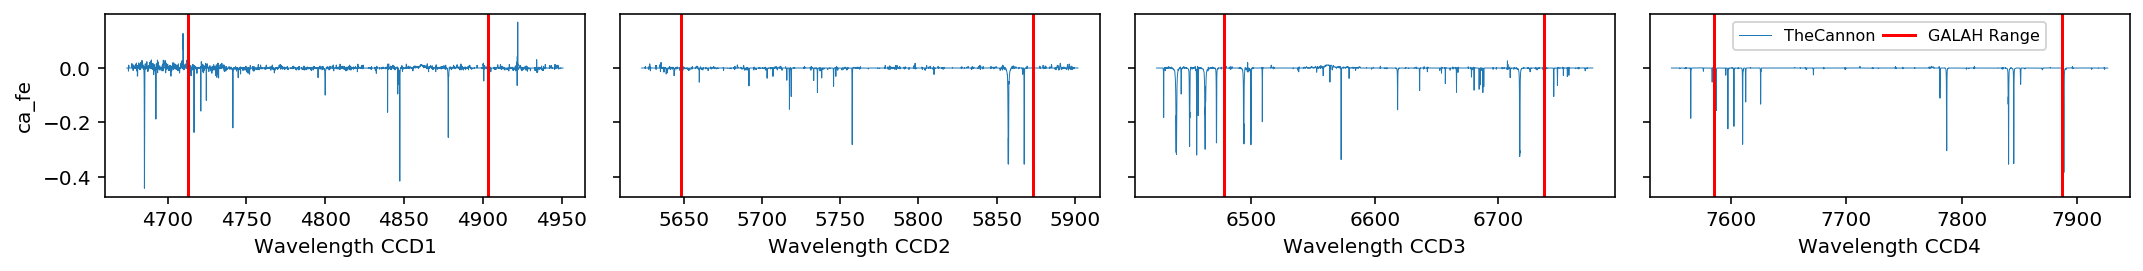

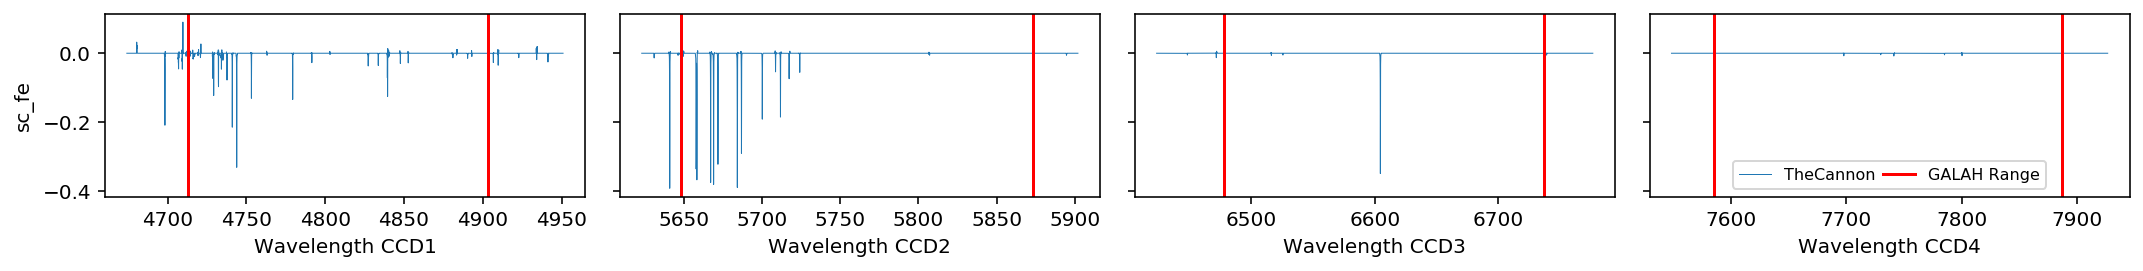

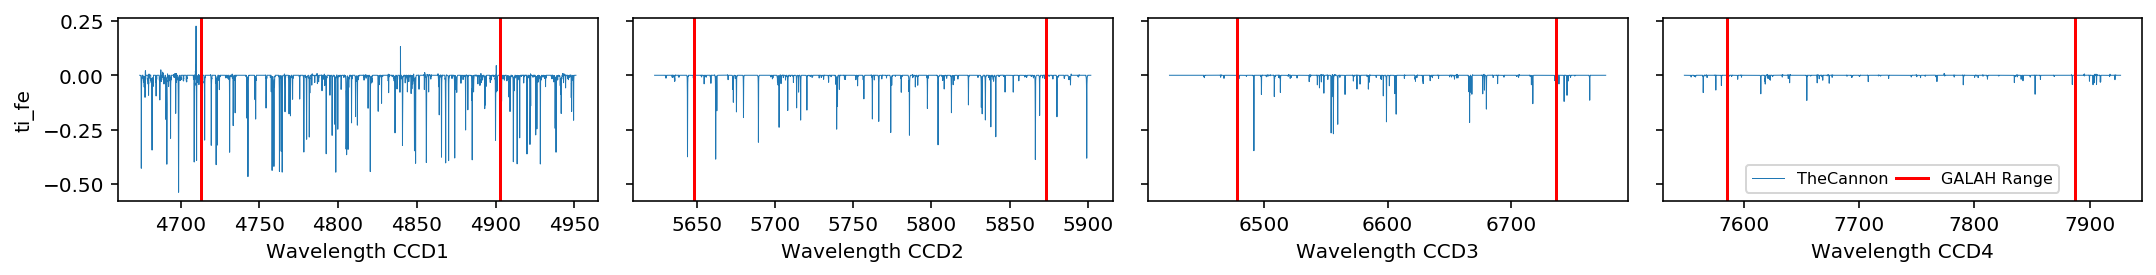

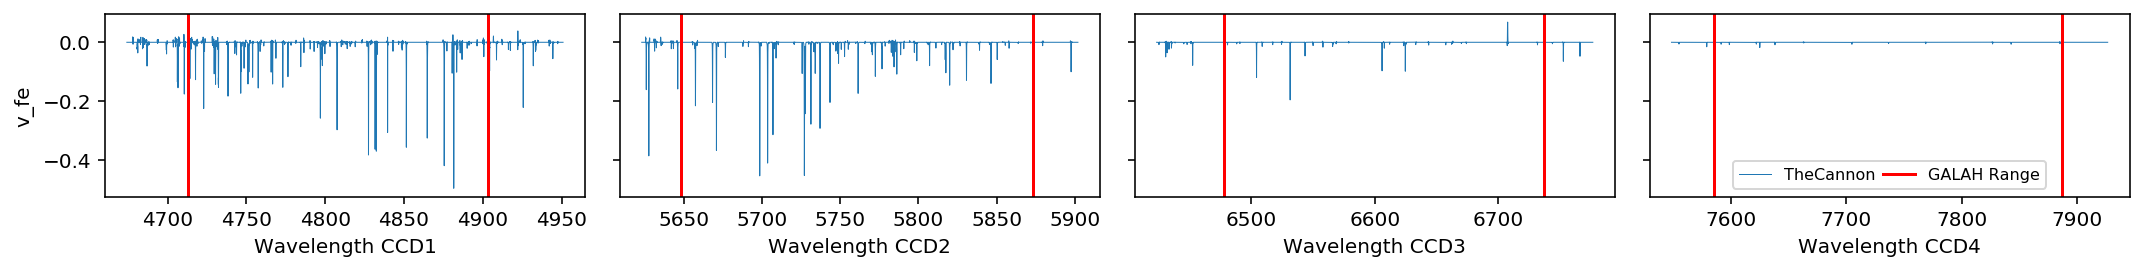

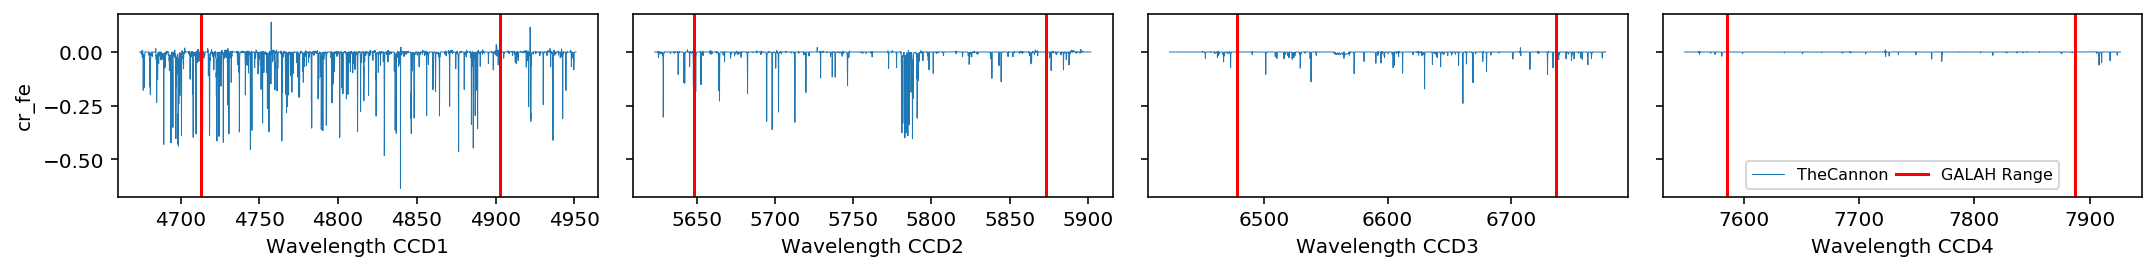

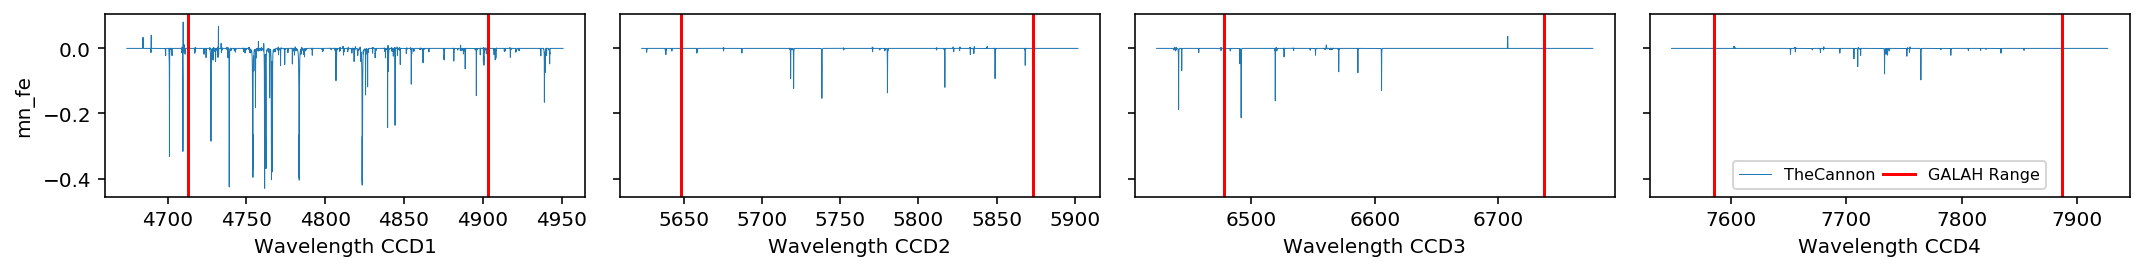

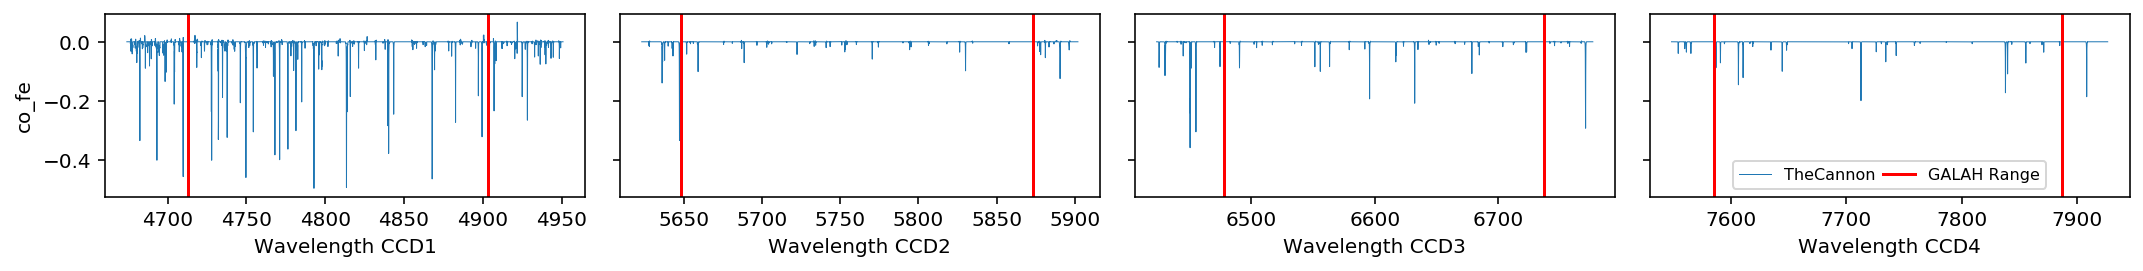

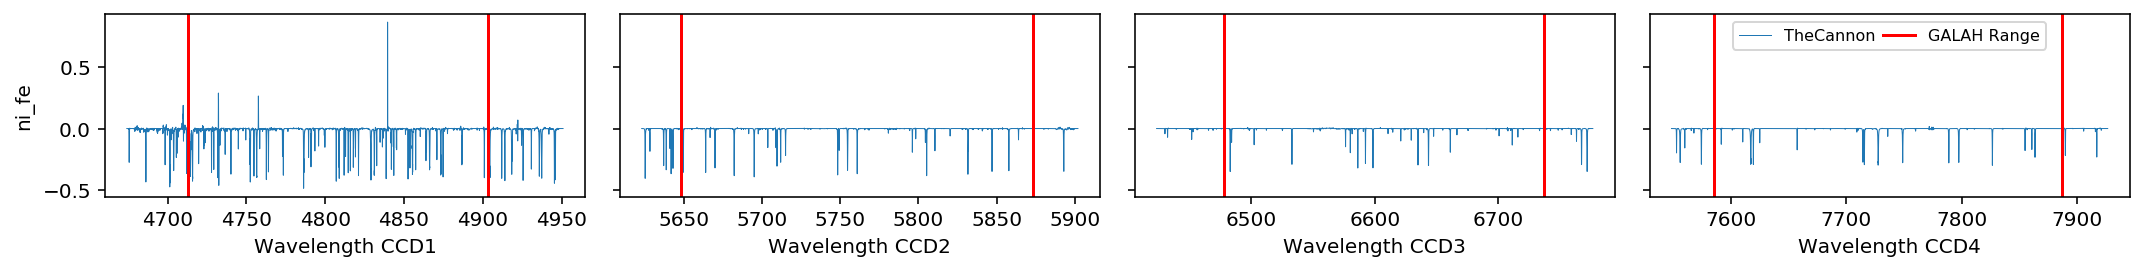

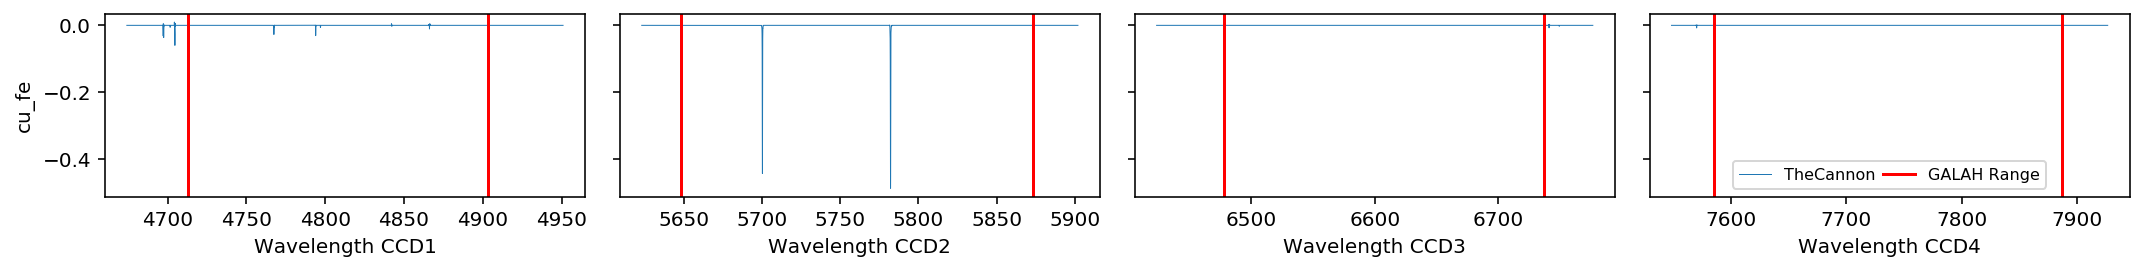

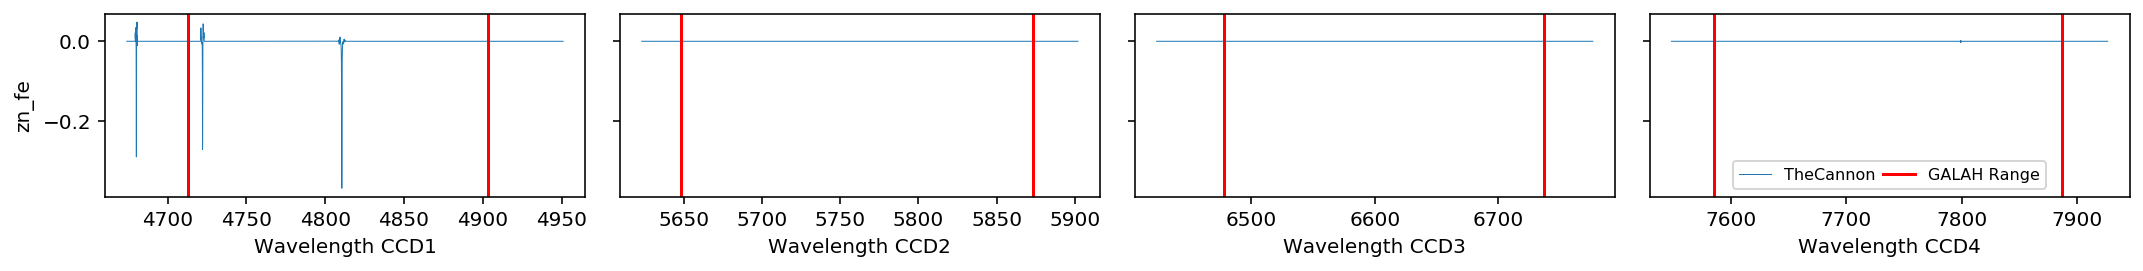

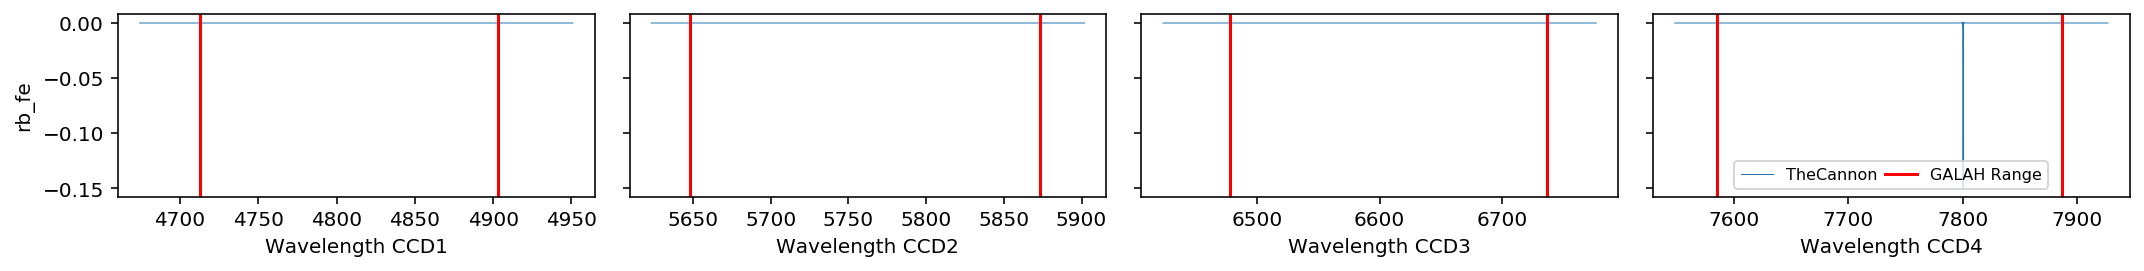

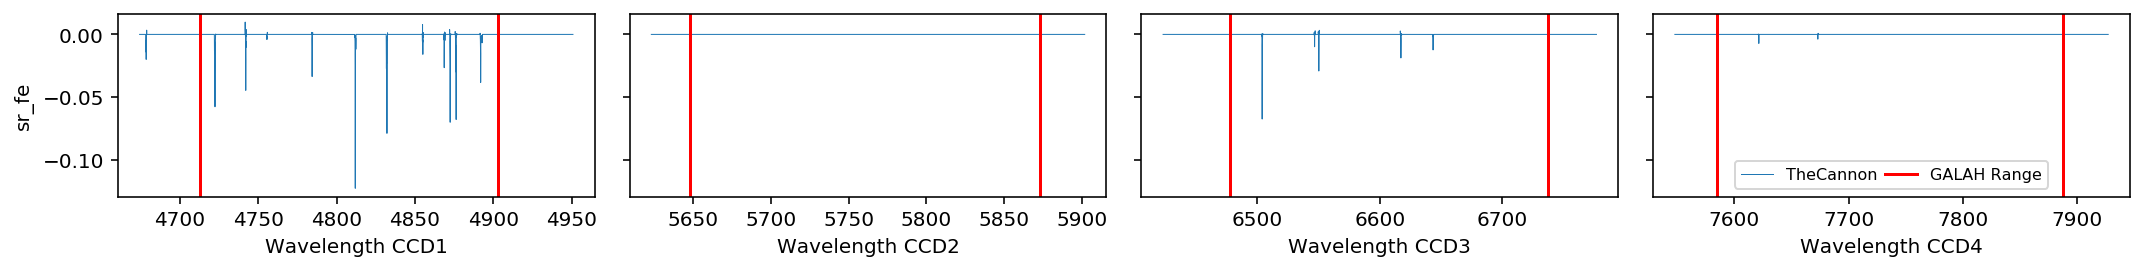

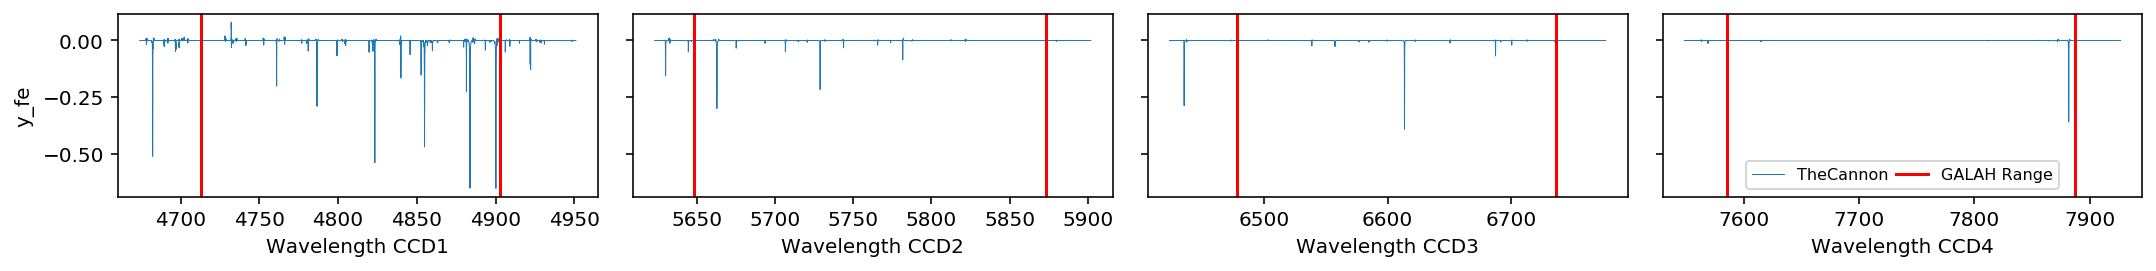

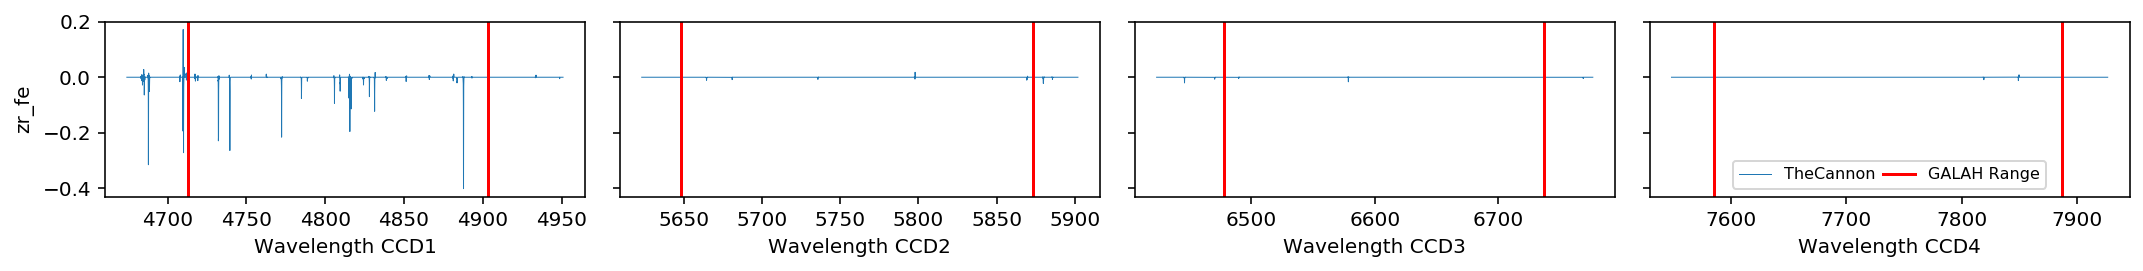

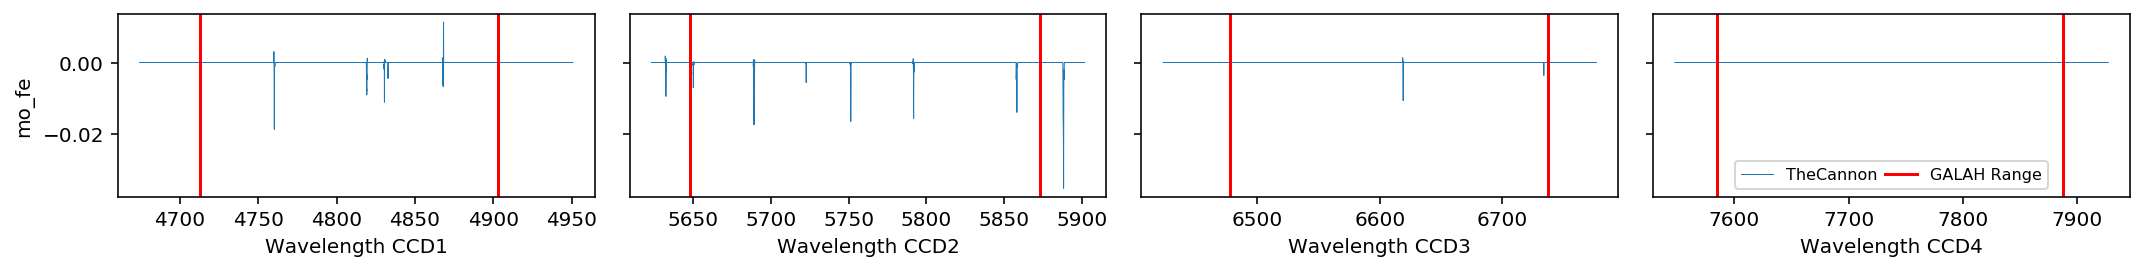

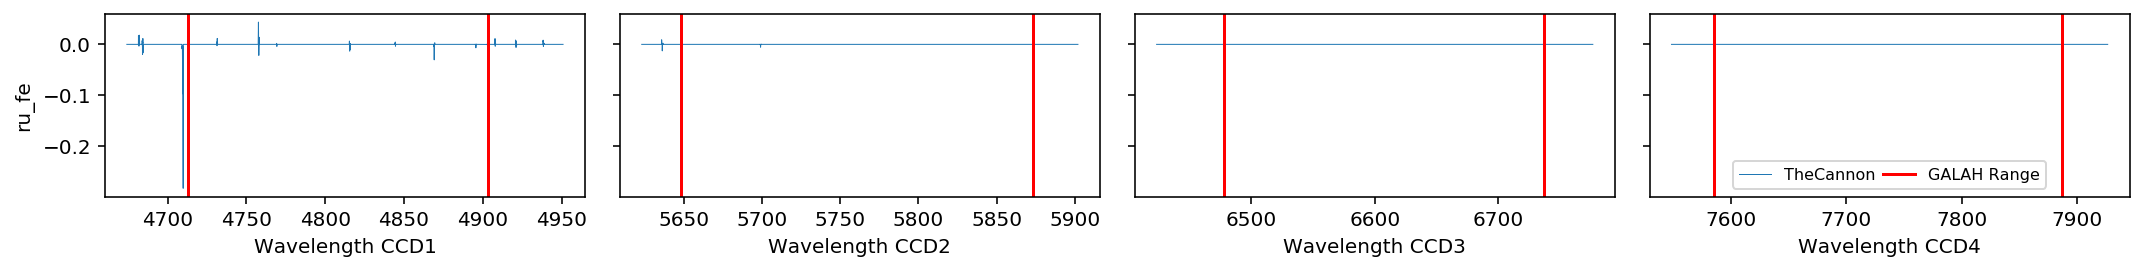

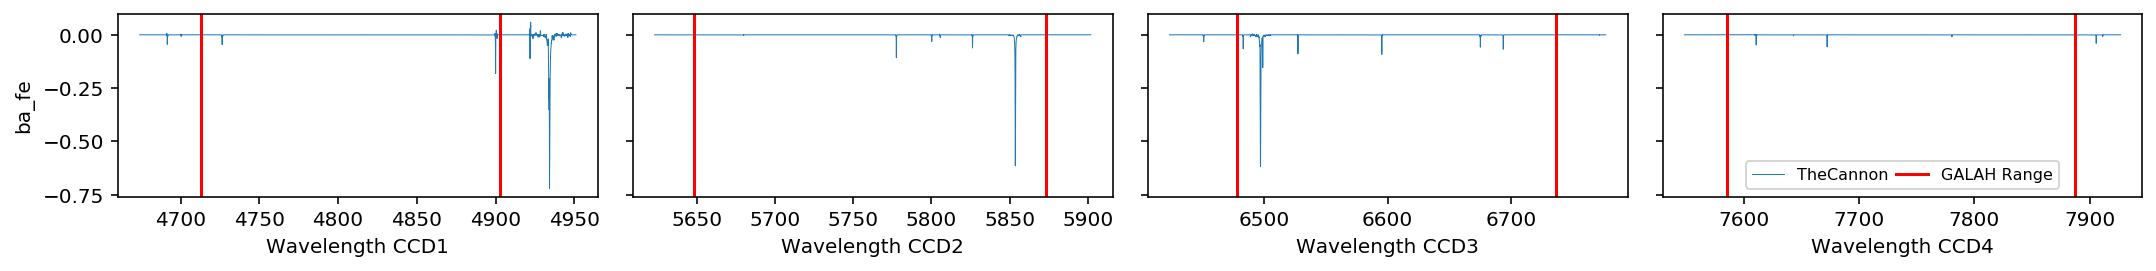

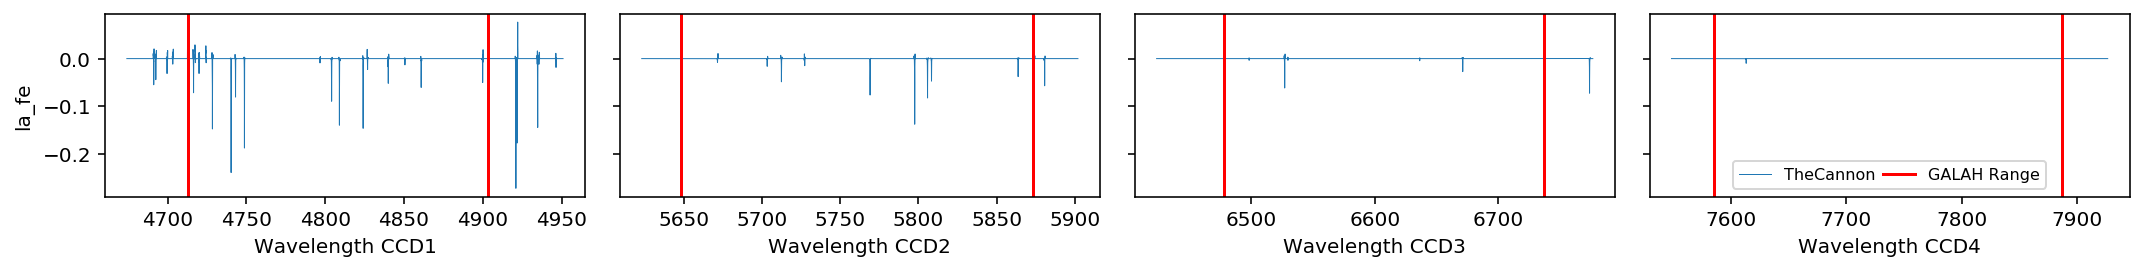

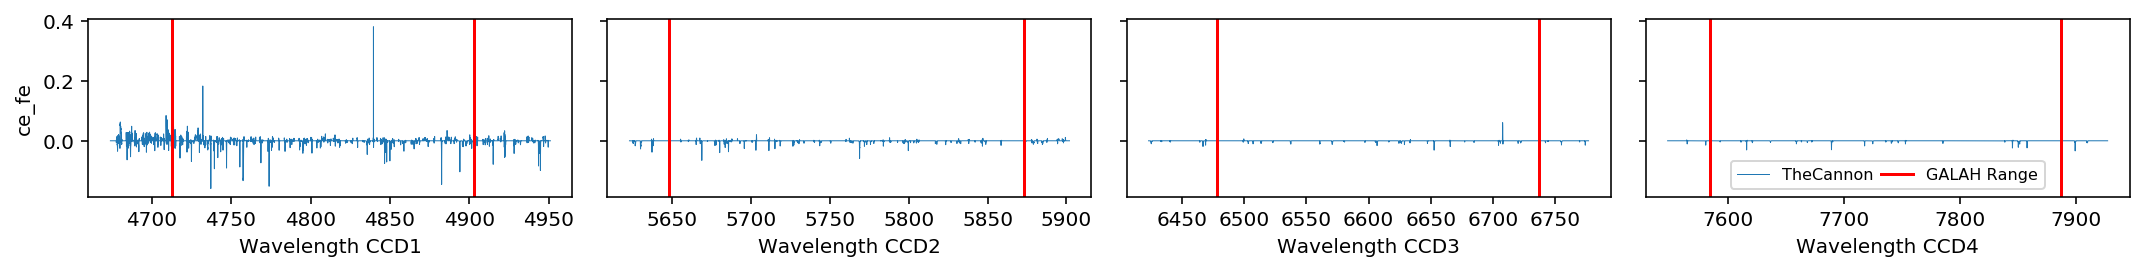

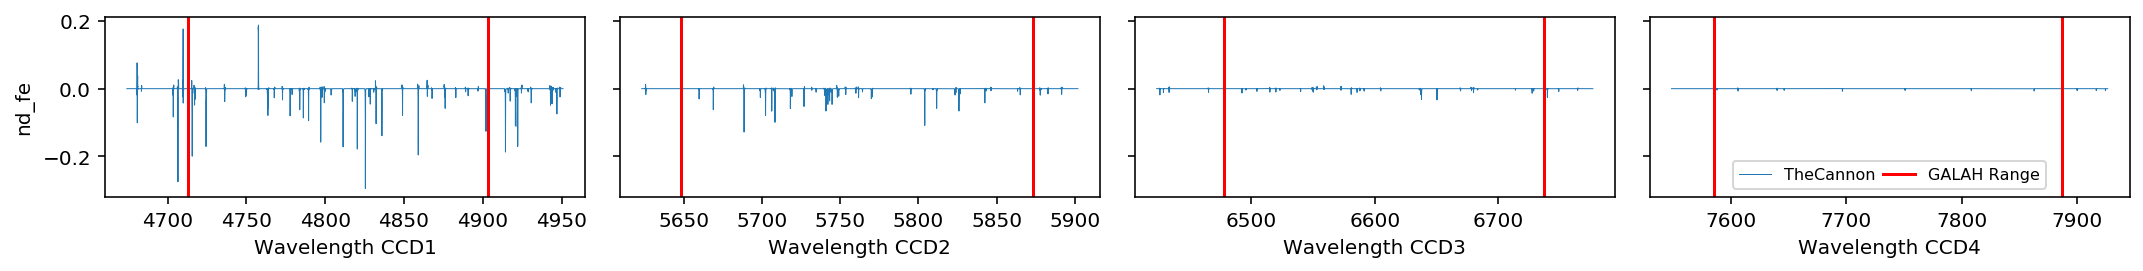

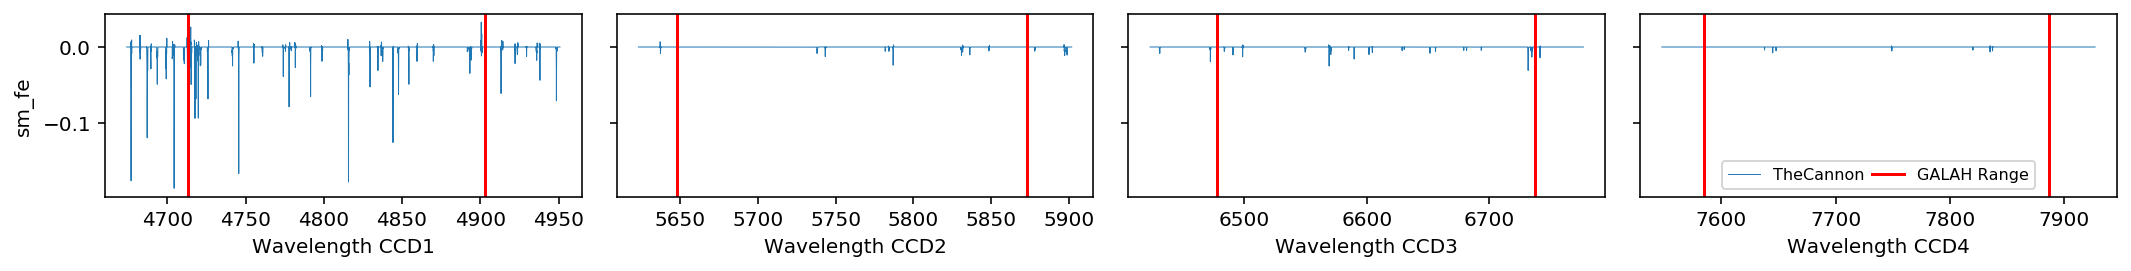

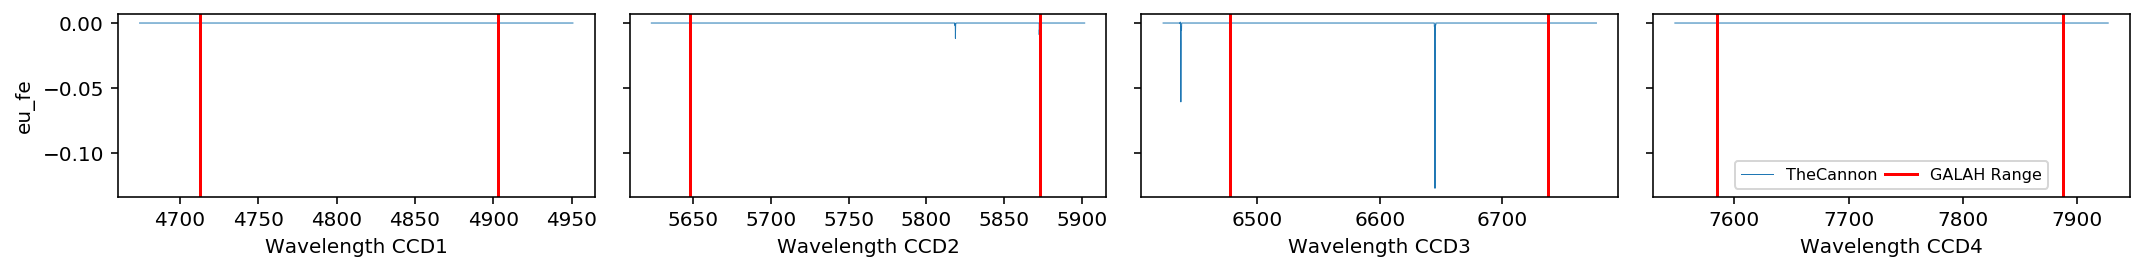

In [16]:
# Now let's plot some of the coefficients to get an idea, which pixels the model considers interesting.
def plot_coefficients(model, index, ccds=[1,2,3,4], overplot_sme=False):
    
    # let's have an option to plot the scatter with a negative index
    if index == -1:
        ylabel = 'scatter'
    else:
        ylabel = model.vectorizer.get_human_readable_label_term(index,
                label_names = model.vectorizer.label_names, mul='\cdot', pow='^')
        
    f, gs = plt.subplots(1,len(ccds),figsize=(15,2),sharey=True)
    
    for ccd in ccds:
        ax=gs[ccd-1]
        
        in_wavelength_range = (wavelength_array >= (3+ccd)*1000) & (wavelength_array <= (4+ccd)*1000)
                                             
        if index == -1:
            ax.plot(
                wavelength_array[in_wavelength_range],
                model.s2[in_wavelength_range]**0.5,
                lw=0.5,c='C0'
            )
            #ax.set_ylim(0,0.1)
        else:
            if (overplot_sme & (index < 36)):
                
                synthetic_spectrum_0 = readsav('../../spectrum_grids/solar_twin_grid/solar_twin_grid_ind_xfe/specout_ind_xfe/solar_twin_grid_210831_0_ccd'+str(ccd)+'_smod_sint.sav').results[0]
                #broadened_smod_0 = apply_gauss_broad(synthetic_spectrum_0.wave,synthetic_spectrum_0.smod,ipres=25000)

                if index == 0:
                    ax.plot(
                        synthetic_spectrum_0.wave,
                        synthetic_spectrum_0.smod,
                        lw=1,c='C1',label='SME'
                    )
                else:
                    synthetic_spectrum_index = readsav('../../spectrum_grids/solar_twin_grid/solar_twin_grid_ind_xfe/specout_ind_xfe/solar_twin_grid_210831_'+str(index)+'_ccd'+str(ccd)+'_smod_sint.sav').results[0]
                    broadened_smod_index = apply_gauss_broad(synthetic_spectrum_index.wave,synthetic_spectrum_index.smod,ipres=25000)
                    rescale = 1
                    if index==5:
                        rescale=7
                    ax.plot(
                        synthetic_spectrum_0.wave,
                        #synthetic_spectrum_index.smod - synthetic_spectrum_0.smod,
                        rescale*(synthetic_spectrum_0.smod - synthetic_spectrum_index.smod),
                        lw=1,c='C1',label='SME'
                    )
            ax.plot(
                wavelength_array[in_wavelength_range],
                model.theta[in_wavelength_range,index],
                lw=0.5,c='C0',label='TheCannon'
            )
        ax.set_xlabel('Wavelength CCD'+str(ccd))
        
        if ccd == 1:
            ax.axvline(4713,color='r')
            ax.axvline(4903,color='r',label='GALAH Range')
        if ccd == 2:
            ax.axvline(5648,color='r')
            ax.axvline(5873,color='r',label='GALAH Range')
        if ccd == 3:
            ax.axvline(6478,color='r')
            ax.axvline(6737,color='r',label='GALAH Range')
        if ccd == 4:
            ax.axvline(7585,color='r')
            ax.axvline(7887,color='r',label='GALAH Range')

        if ccd==ccds[-1]:
            ax.legend(ncol=3,fontsize=8,columnspacing=0.5)

        if ccd==1:
            ax.set_ylabel(ylabel)
    plt.tight_layout()
    #plt.savefig('coefficient_plots/pm1dex_35labels/solar_twin_grid_pm1dex_35labels_coeff_'+ylabel+'.png',dpi=300,bbox_inches='tight')
    plt.show()
    plt.close()

#for index in range(-1,np.shape(model.theta)[1]):
for index in range(-1,len(labels)+1):
    plot_coefficients(model, index, ccds=[1,2,3,4], overplot_sme=False)

In [ ]:
test_labels, cov, metadata = model.test(training_set_flux, training_set_ivar)

In [ ]:
fig_comparison = tc.plot.one_to_one(model, test_labels)
fig_comparison.savefig('diagnostic_plots/'+model_file+'_cross.png',dpi=200,bbox_inches='tight')

In [ ]:
training_set['dteff'] = np.round(training_set['teff'] - test_labels[:,0],decimals=0)
training_set['dlogg'] = np.round(training_set['logg'] - test_labels[:,1],decimals=2)
training_set['dfe_h'] = np.round(training_set['fe_h'] - test_labels[:,2],decimals=2)
training_set['c_teff'] = np.round(test_labels[:,0],decimals=0)
training_set['c_logg'] = np.round(test_labels[:,1],decimals=2)
training_set['c_fe_h'] = np.round(test_labels[:,2],decimals=2)

In [ ]:
# comparison in TEFF/LOGG/FEH
f, gs = plt.subplots(2,2,sharex=True,sharey=True,figsize=(10,8))
ax=gs[0,0]
ax.set_title('SME')
for feh in np.unique(training_set['fe_h']):
    in_fe_h = (training_set['fe_h'] == feh)
    s = ax.scatter(
        training_set['teff'][in_fe_h],
        training_set['logg'][in_fe_h],
        c=training_set['fe_h'][in_fe_h],
        s=40-50*training_set['fe_h'][in_fe_h],
        vmin=np.min(training_set['fe_h']),vmax=np.max(training_set['fe_h'])
    )
c = plt.colorbar(s,ax=ax)
c.set_label('SME [Fe/H]')

ax.set_xlabel('$T_{eff}$ / K')
ax.set_ylabel(r'$\log$ ($g$ / cm s$^{-2}$)')

ax=gs[0,1]
ax.set_title('$The$ $Cannon$')
s = ax.scatter(
    test_labels[:,0],
    test_labels[:,1],
    c = training_set['teff']-test_labels[:,0]
)
ax.set_xlabel('$T_{eff}$ / K')
c = plt.colorbar(s,ax=ax)
c.set_label('SME $T_{eff}$ / K')

ax=gs[1,0]
ax.set_title('$The$ $Cannon$')
s = ax.scatter(
    test_labels[:,0],
    test_labels[:,1],
    c = training_set['logg']-test_labels[:,1]
)
ax.set_xlabel('$T_{eff}$ / K')
c = plt.colorbar(s,ax=ax)
c.set_label('SME $\log$ ($g$ / cm s$^{-2}$)')

ax=gs[1,1]
ax.set_title('$The$ $Cannon$')
s = ax.scatter(
    test_labels[:,0],
    test_labels[:,1],
    c = training_set['fe_h']-test_labels[:,2]
)
ax.set_xlabel('$T_{eff}$ / K')
c = plt.colorbar(s,ax=ax)
c.set_label('SME [Fe/H]')
ax.invert_xaxis()
ax.invert_yaxis()
#ax.set_xlim(6750,4000)
#ax.set_ylim(5.5,2.75)

plt.tight_layout()
plt.savefig('diagnostic_plots/'+model_file+'_tefflogg.png')